In [6]:
import numpy as np
from sklearn.preprocessing import normalize
from sim_data import sim
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor

In [7]:
n, p = 5000, 10

beta_LS, beta_RT_LS, beta_LS_SIR = [], [], []
n_sim = 1
for i in range(n_sim):
	# theta0 = np.random.randn(p)
	theta0 = np.ones(p)
	theta0 = theta0 / np.sqrt(np.sum(theta0**2))
	beta0 = 1.
	Z, X, y, phi = sim(n, p, theta0, beta0, case='linear', feat='normal', range=1., return_phi=True)
	## test
	# ind_tmp = np.where(X>2.5)[0]
	# Z, X, y, phi = Z[ind_tmp], X[ind_tmp], y[ind_tmp], phi[ind_tmp]
	# n = len(X)
	## normalize Z, X, y
	center = StandardScaler(with_std=False)
	Z, X, y, phi = center.fit_transform(Z), X - X.mean(), y - y.mean(), phi - phi.mean()
	LD_Z, cor_ZX, cor_ZY = np.dot(Z.T, Z), np.dot(Z.T, X), np.dot(Z.T, y)

	## solve by SIR+LS
	from nonlinear_causal import _2SCausal
	echo = _2SCausal._2SIR(sparse_reg=None)
	# echo.cond_mean = KernelRidge(kernel='rbf', alpha=.001, gamma=.1)
	echo.cond_mean = KNeighborsRegressor(n_neighbors=20)
	echo.fit(Z, X, cor_ZY)
	print('est beta based on 2SIR: %.3f' %echo.beta)
	pred_phi = echo.link(X=X[:,None]).flatten()
	pred_mean = np.sign(echo.beta)* echo.cond_mean.predict(X=X[:,None]).flatten()

	# beta_LS.append(abs(LS.beta))
	# beta_RT_LS.append(abs(RT_LS.beta))
	# beta_LS_SIR.append(abs(echo.beta[0]))

est beta based on 2SIR: -1.007


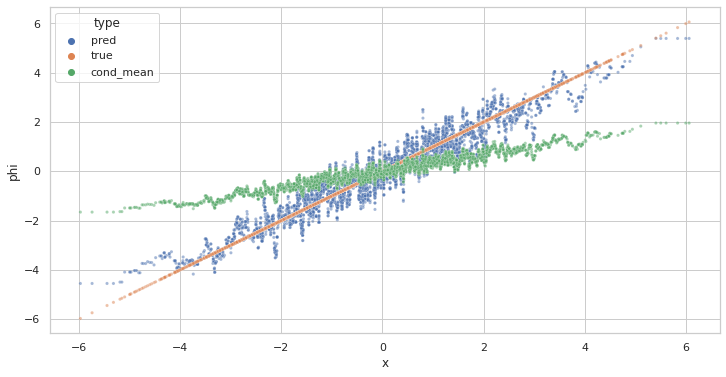

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)
sns.set_theme(style="whitegrid")
d = {'x': list(X)*3, 'phi':list(pred_phi)+list(phi)+list(pred_mean), 
		'type':['pred']*n+['true']*n+['cond_mean']*n}
# ax = sns.regplot(x=X, y=pred_phi,
# 				scatter_kws={"s": 20},
# 				order=2, ci=None)
sns.scatterplot(data=d, x="x", y="phi", hue="type", s=10, alpha=.5)
plt.show()